# Class 16 - Solution Code

Exploring Walmart Sales Data

In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

### Load Dataset and Pre-Process

Walmart Sales Data

For this exercise, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


In [22]:
# Load data
data = pd.read_csv('../../assets/dataset/train.csv')

# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [23]:
# Convert to datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Use `Date` as index
data.set_index('Date', inplace=True)

# Check sample
data.sample(5)

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2011-06-03,13,9,49863.68,False
2012-08-31,7,96,1164.34,False
2012-05-25,16,33,2158.81,False
2012-01-13,15,34,8455.89,False
2010-02-05,31,42,4596.97,False


### 1.1 Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [24]:
# Filter to store 1 sales and average over weeks
store1_sales = data[data['Store']==1]

# Aggregate weekly total sales
store1_sales = store1_sales[['Weekly_Sales']].resample('W').sum()

# Check weekly total sales
store1_sales.head()

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


### 1.2 Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

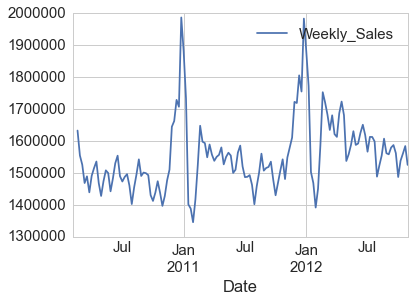

In [25]:
store1_sales[['Weekly_Sales']].rolling(window=3).mean().plot()

### 1.3 Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [26]:
print 'Autocorrelation 1:  ', store1_sales['Weekly_Sales'].autocorr(1)
print 'Autocorrelation 2:  ', store1_sales['Weekly_Sales'].autocorr(2)
print 'Autocorrelation 52: ', store1_sales['Weekly_Sales'].autocorr(52)

Autocorrelation 1:   0.302158279411
Autocorrelation 2:   0.127413130554
Autocorrelation 52:  0.895376029478


### 1.4 Create an autocorrelation plot. What does the autocorrelation plot say about the type of model you want to build?

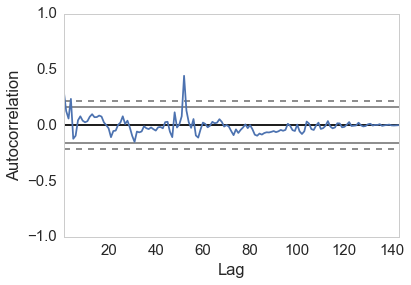

In [27]:
from pandas.tools.plotting import autocorrelation_plot

# Plot autocorrelation plot using Pandas
autocorrelation_plot(store1_sales['Weekly_Sales'])

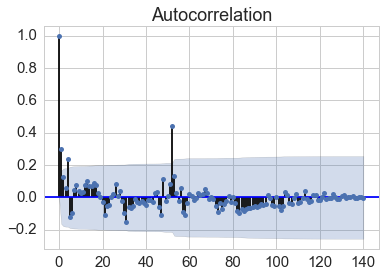

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation plot using Statsmodels
p = plot_acf(store1_sales['Weekly_Sales'], lags=140)

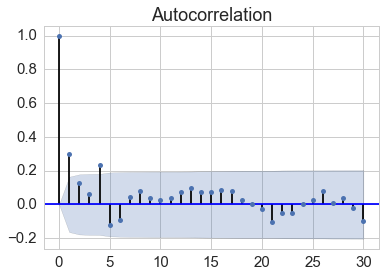

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

p = plot_acf(store1_sales['Weekly_Sales'], lags=30)

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

### 1.5 Split the weekly sales data in a training and test set - using 75% of the data for training

In [30]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.75*n)]
test = store1_sales.Weekly_Sales[int(.75*n):]

print min(test.index)
print max(test.index)

2012-02-26 00:00:00
2012-10-28 00:00:00


### 1.6 Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [31]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [32]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=False, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81839.338629691949)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Mon, 18 Jul 2016   AIC                           2875.327
Time:                        20:18:06   BIC                           2883.345
Sample:                    02-07-2010   HQIC                          2878.577
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001         0.133     0.496
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1779           +0.0000j            3.1779            0.0000
-----------------------------------------------------------------------------
"""

### 1.7 Plot the residuals - where are their significant errors.

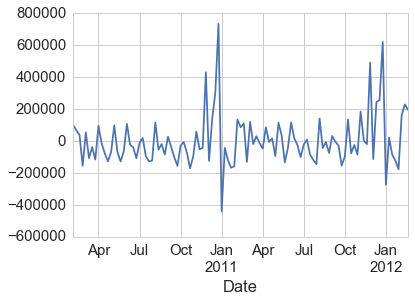

In [33]:
model.resid.plot()

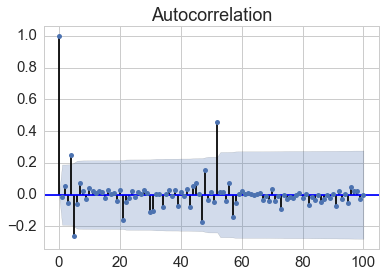

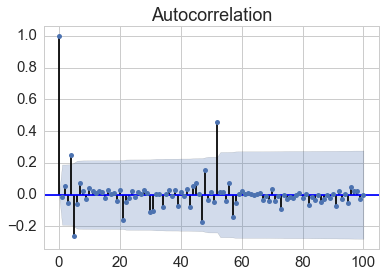

In [34]:
plot_acf(model.resid, lags=100)

### 1.8 Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [35]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81203.239439475758)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Mon, 18 Jul 2016   AIC                           2876.963
Time:                        20:18:06   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003         0.108     0.487
ar.L2.Weekly_Sales     0.0589      0.098      0.603      0.548        -0.132     0.250
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3080           +0.0000j            2.3080            0.0000
AR.2           -7.3588           +0.0000j            7.3588            0.5000
-----------------------------------------------------------------------------
"""

In [36]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 80504.213792850991)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144099.807
Date:                Mon, 18 Jul 2016   AIC                           2863.563
Time:                        20:18:07   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.320      0.000      1.51e+06  1.58e+06
ar.L1.Weekly_Sales    -1.0398      0.090    -11.583      0.000        -1.216    -0.864
ar.L2.Weekly_Sales    -0.4701      0.087     -5.380      0.000        -0.641    -0.299
ma.L1.Weekly_Sales     1.4693      0.058     25.393      0.000         1.356     1.583
ma.L2.Weekly_Sales     1.0000      0.074     13.532      0.000         0.855     1.145
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1059           -0.9509j            1.4585           -0.3870
AR.2           -1.1059           +0.9509j            1.4585            0.3870
MA.1           -0.7347           -0.6785j            1.0000           -0.3813
MA.2           -0.7347           +0.6785j            1.0000            0.3813
-----------------------------------------------------------------------------
"""

### 1.9 Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [40]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 77840.625511039907)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  106
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1413.597
Method:                       css-mle   S.D. of innovations         142916.804
Date:                Mon, 18 Jul 2016   AIC                           2841.193
Time:                        20:18:30   BIC                           2859.837
Sample:                    02-14-2010   HQIC                          2848.750
                         - 02-19-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  592.7717    620.927      0.955      0.342      -624.222  1809.766
ar.L1.D.Weekly_Sales    -1.0487      0.090    -11.617      0.000        -1.226    -0.872
ar.L2.D.Weekly_Sales    -0.4789      0.088     -5.457      0.000        -0.651    -0.307
ma.L1.D.Weekly_Sales     0.4695      0.099      4.747      0.000         0.276     0.663
ma.L2.D.Weekly_Sales    -0.4693      0.124     -3.794      0.000        -0.712    -0.227
ma.L3.D.Weekly_Sales    -0.9997      0.108     -9.282      0.000        -1.211    -0.789
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0948           -0.9430j            1.4450           -0.3868
AR.2           -1.0948           +0.9430j            1.4450            0.3868
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -0.7348           -0.6784j            1.0001           -0.3813
MA.3           -0.7348           +0.6784j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

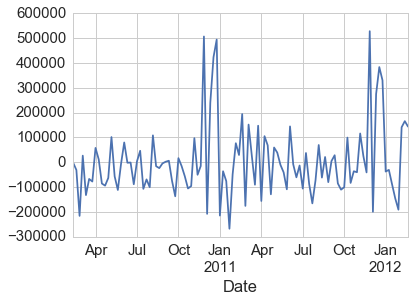

In [41]:
model.resid.plot()